### To Unzip the Image Folders

In [ ]:
# import zipfile
# import os

# zip_file_path = "Data/monet_jpg.zip"
# extract_to_path = "Data/monet_jpg"

# # Ensure the extraction directory exists
# os.makedirs(extract_to_path, exist_ok=True)

# # Open the ZIP file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

# print(f"Files extracted to: {extract_to_path}")

In [ ]:
# zip_file_path = "Data/photo_jpg.zip"
# extract_to_path = "Data/photo_jpg"

# # Ensure the extraction directory exists
# os.makedirs(extract_to_path, exist_ok=True)

# # Open the ZIP file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

# print(f"Files extracted to: {extract_to_path}")

In [ ]:
# !pip install scipy

In [ ]:
# !pip install matplotlib

In [ ]:
from torch.nn.utils import spectral_norm
import torch
import torch.nn as nn
from torchvision.models import inception_v3
import numpy as np
from scipy import linalg
from torch.utils.data import DataLoader
from tqdm import tqdm

### Display a sample of Images

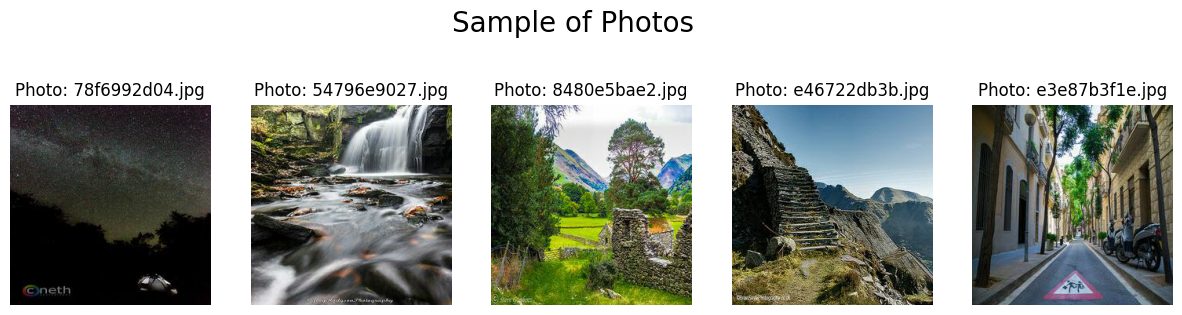

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Paths to the two folders where images are extracted
photos_path = 'Data/photo_jpg'
monet_path = 'Data/monet_jpg'

# Get the list of image files in each folder
photos_files= [f for f in os.listdir(photos_path) if f.endswith(('png', 'jpg', 'jpeg', 'gif'))]
monet_files = [f for f in os.listdir(monet_path) if f.endswith(('png', 'jpg', 'jpeg', 'gif'))]

# Sample size: number of images to display from each folder
sample_size = 5

# Take a random sample of image files (or use the first `sample_size` images) from both folders
sampled_photos = random.sample(photos_files, min(sample_size, len(photos_files)))
sampled_monets = random.sample(monet_files, min(sample_size, len(monet_files)))

# Create a figure to display the images
plt.figure(figsize=(15, 10))
plt.suptitle('Sample of Photos', fontsize=20, y=0.9)

for i, image_file in enumerate(sampled_photos):
    image_path = os.path.join(photos_path, image_file)

    # Open the image
    img = Image.open(image_path)

    # Display the image in a subplot
    plt.subplot(2, sample_size, i+1)
    plt.imshow(img)
    plt.title(f"Photo: {image_file}")
    plt.axis('off')


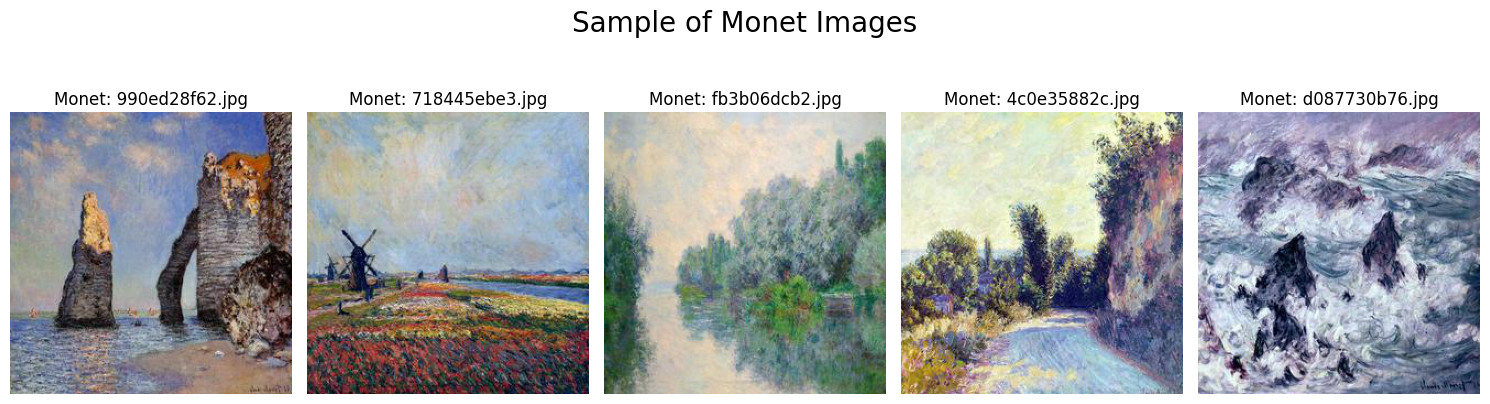

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle('Sample of Monet Images', fontsize=20, y=0.5)

for i, image_file in enumerate(sampled_monets):
    image_path = os.path.join(monet_path, image_file)

    # Open the image
    img = Image.open(image_path)

    # Display the image in a subplot
    plt.subplot(2, sample_size, sample_size + i + 1)  # Two rows, sample_size columns
    plt.imshow(img)
    plt.title(f"Monet: {image_file}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# U-GAT-IT

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, photo_path, monet_path, transform=None):
        # Load all photo file paths from the specified directory with supported image formats
        self.photo_files = [os.path.join(photo_path, x) for x in os.listdir(photo_path)
                           if x.endswith(('png', 'jpg', 'jpeg'))]
        # Load all Monet file paths from the specified directory with supported image formats
        self.monet_files = [os.path.join(monet_path, x) for x in os.listdir(monet_path)
                           if x.endswith(('png', 'jpg', 'jpeg'))]

        # Store the number of photo and Monet images
        self.photo_size = len(self.photo_files)
        self.monet_size = len(self.monet_files)
        self.transform = transform

    def __getitem__(self, index):
        # Load a photo image based on the index, cycling back if index exceeds size
        photo_img = Image.open(self.photo_files[index % self.photo_size]).convert('RGB')

        # Load a random Monet image to pair with the photo
        monet_img = Image.open(self.monet_files[random.randint(0, self.monet_size - 1)]).convert('RGB')

        # Apply transformations to both images if provided
        if self.transform:
            photo_img = self.transform(photo_img)
            monet_img = self.transform(monet_img)

        # Return the transformed photo image, Monet image, and the photo file path
        return photo_img, monet_img, self.photo_files[index % self.photo_size]

    def __len__(self):
        # Return the number of photo images as the size of the dataset
        return self.photo_size


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, dim, use_bias=True):
        super(ResBlock, self).__init__()

        # Input and output have the same number of channels (dim)
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=use_bias)

        # This also maintains the same number of channels (dim)
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=use_bias)

        # Instance normalization for the first convolution's output
        self.norm1 = nn.InstanceNorm2d(dim)

        # Instance normalization for the second convolution's output
        self.norm2 = nn.InstanceNorm2d(dim)

    def forward(self, x):
        # Pass the input through the first convolution, apply instance normalization, and ReLU activation
        out = F.relu(self.norm1(self.conv1(x)))

        # Pass the result through the second convolution and apply instance normalization
        out = self.norm2(self.conv2(out))

        return x + out

In [ ]:
class AdaILN(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(AdaILN, self).__init__()
        self.eps = eps
        self.rho = nn.Parameter(torch.Tensor(1, num_features, 1, 1))
        self.rho.data.fill_(0.9)

    def forward(self, x, gamma, beta):
        in_mean, in_var = torch.mean(x, dim=[2, 3], keepdim=True), torch.var(x, dim=[2, 3], keepdim=True)
        out_in = (x - in_mean) / torch.sqrt(in_var + self.eps)
        ln_mean, ln_var = torch.mean(x, dim=[1, 2, 3], keepdim=True), torch.var(x, dim=[1, 2, 3], keepdim=True)
        out_ln = (x - ln_mean) / torch.sqrt(ln_var + self.eps)
        out = self.rho.expand(x.shape[0], -1, -1, -1) * out_in + (1-self.rho.expand(x.shape[0], -1, -1, -1)) * out_ln
        out = out * gamma.unsqueeze(2).unsqueeze(3) + beta.unsqueeze(2).unsqueeze(3)
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=6):
        super(Generator, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            spectral_norm(nn.Conv2d(input_nc, ngf, kernel_size=7, stride=1, padding=0, bias=False)),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        )
        self.enc2 = nn.Sequential(
            spectral_norm(nn.Conv2d(ngf, ngf*2, kernel_size=3, stride=2, padding=1, bias=False)),
            nn.InstanceNorm2d(ngf*2),
            nn.ReLU(True)
        )
        self.enc3 = nn.Sequential(
            spectral_norm(nn.Conv2d(ngf*2, ngf*4, kernel_size=3, stride=2, padding=1, bias=False)),
            nn.InstanceNorm2d(ngf*4),
            nn.ReLU(True)
        )

        # Bottleneck
        blocks = []
        for _ in range(n_blocks):
            blocks.append(ResBlock(ngf*4))
        self.bottleneck = nn.Sequential(*blocks)

        # CAM
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.gmp = nn.AdaptiveMaxPool2d(1)
        self.cam_conv = nn.Conv2d(ngf*4, 1, kernel_size=1, stride=1, bias=True)

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(ngf*2),
            nn.ReLU(True)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        )
        self.dec3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoding
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)

        # Bottleneck
        x = self.bottleneck(x)

        # CAM
        gap = self.gap(x)
        gmp = self.gmp(x)
        cam_logit = self.cam_conv(x)
        x = x * torch.sigmoid(cam_logit)

        # Decoding
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)

        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc=3, ndf=64):
        super(Discriminator, self).__init__()

        # Initialize weights with smaller values
        def init_weights(m):
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.InstanceNorm2d):
                if m.weight is not None:
                    m.weight.data.normal_(1.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

        # Main convolutional blocks with spectral normalization
        self.conv1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, True)
        )
        self.conv2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True)
        )
        self.conv3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(ndf*4),
            nn.LeakyReLU(0.2, True)
        )
        self.conv4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, True)
        )

        # CAM layers with spectral normalization
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.gmp = nn.AdaptiveMaxPool2d(1)
        self.cam = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(ndf*8*2, ndf*8, kernel_size=1, stride=1, bias=True)),
            nn.LeakyReLU(0.2, True)
        )

        # Output convolution with spectral normalization
        self.out_conv = nn.utils.spectral_norm(
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=1)
        )

        # Apply weight initialization
        self.apply(init_weights)

    def forward(self, x):
        # Add small noise for stability
        if self.training:
            x = x + torch.randn_like(x) * 0.05

        # Main feature extraction
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        feat = self.conv4(x)

        # CAM mechanism
        gap = self.gap(feat)
        gmp = self.gmp(feat)
        cam_logit = torch.cat([gap, gmp], dim=1)
        cam_logit = self.cam(cam_logit)

        # Apply attention and scale properly
        heatmap = torch.sum(feat * cam_logit, dim=1, keepdim=True)
        heatmap = torch.sigmoid(heatmap)  # Normalize attention weights
        attn_feat = feat * heatmap

        # Final output with proper scaling
        out = self.out_conv(attn_feat)

        return out, cam_logit

In [ ]:
class UGATIT:
    def __init__(self, device):
        self.device = device
        self.G_A2B = Generator().to(device)
        self.G_B2A = Generator().to(device)
        self.D_A = Discriminator().to(device)
        self.D_B = Discriminator().to(device)

        # Initialize optimizers
        self.g_optimizer = torch.optim.Adam(
            list(self.G_A2B.parameters()) + list(self.G_B2A.parameters()),
            lr=0.0001,
            betas=(0.5, 0.999)
        )
        self.d_optimizer = torch.optim.Adam(
            list(self.D_A.parameters()) + list(self.D_B.parameters()),
            lr=0.0001,
            betas=(0.5, 0.999)
        )

        # Loss functions
        self.criterion_GAN = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()


    def compute_gradient_penalty(self, discriminator, real_samples, fake_samples):
        alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(self.device)
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates, _ = discriminator(interpolates)
        fake = torch.ones(real_samples.size(0), 1, d_interpolates.size(2), d_interpolates.size(3)).to(self.device)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    # Update the train_step method in UGATIT class:
    def train_step(self, real_A, real_B):
        real_A = real_A.to(self.device)
        real_B = real_B.to(self.device)
        batch_size = real_A.size(0)

        # Generate fake images
        with torch.no_grad():
            fake_B = self.G_A2B(real_A)
            fake_A = self.G_B2A(real_B)

        # Train Discriminators

        self.d_optimizer.zero_grad()

        # Add noise to discriminator inputs for stability
        real_A_noisy = real_A + torch.randn_like(real_A) * 0.05
        real_B_noisy = real_B + torch.randn_like(real_B) * 0.05
        fake_A_noisy = fake_A.detach() + torch.randn_like(fake_A) * 0.05
        fake_B_noisy = fake_B.detach() + torch.randn_like(fake_B) * 0.05

        # Discriminator A
        real_out_A, real_cam_A = self.D_A(real_A_noisy)
        fake_out_A, fake_cam_A = self.D_A(fake_A_noisy)

        # Use binary cross entropy loss instead of MSE
        D_A_real_loss = -torch.mean(torch.log(torch.sigmoid(real_out_A) + 1e-7))
        D_A_fake_loss = -torch.mean(torch.log(1 - torch.sigmoid(fake_out_A) + 1e-7))
        D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5

        # Discriminator B
        real_out_B, real_cam_B = self.D_B(real_B_noisy)
        fake_out_B, fake_cam_B = self.D_B(fake_B_noisy)

        D_B_real_loss = -torch.mean(torch.log(torch.sigmoid(real_out_B) + 1e-7))
        D_B_fake_loss = -torch.mean(torch.log(1 - torch.sigmoid(fake_out_B) + 1e-7))
        D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5

        # CAM losses
        D_A_cam_loss = torch.mean(torch.abs(real_cam_A - fake_cam_A)) * 0.1  # Reduced weight
        D_B_cam_loss = torch.mean(torch.abs(real_cam_B - fake_cam_B)) * 0.1  # Reduced weight

        # Total discriminator loss with proper scaling
        D_loss = (D_A_loss + D_B_loss) * 0.5 + (D_A_cam_loss + D_B_cam_loss) * 0.5

        # Clip gradients before backward pass
        D_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.D_A.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(self.D_B.parameters(), max_norm=1.0)

        # Apply gradient scaling
        for param in self.D_A.parameters():
            param.grad = param.grad * 0.5 if param.grad is not None else None
        for param in self.D_B.parameters():
            param.grad = param.grad * 0.5 if param.grad is not None else None

        self.d_optimizer.step()


        # Train Generators

        self.g_optimizer.zero_grad()

        # Identity loss
        same_B = self.G_A2B(real_B)
        same_A = self.G_B2A(real_A)
        identity_loss = (self.criterion_identity(same_A, real_A) +
                        self.criterion_identity(same_B, real_B)) * 5.0

        # GAN loss
        fake_B = self.G_A2B(real_A)
        fake_A = self.G_B2A(real_B)
        fake_out_A, fake_cam_A = self.D_A(fake_A)
        fake_out_B, fake_cam_B = self.D_B(fake_B)

        G_A2B_loss = -torch.mean(torch.log(torch.sigmoid(fake_out_B) + 1e-7))
        G_B2A_loss = -torch.mean(torch.log(torch.sigmoid(fake_out_A) + 1e-7))

        # Cycle loss
        recovered_A = self.G_B2A(fake_B)
        recovered_B = self.G_A2B(fake_A)
        cycle_loss = (self.criterion_cycle(recovered_A, real_A) +
                     self.criterion_cycle(recovered_B, real_B)) * 10.0

        # Total generator loss
        G_loss = G_A2B_loss + G_B2A_loss + cycle_loss + identity_loss

        # Backward pass with gradient clipping
        G_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.G_A2B.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(self.G_B2A.parameters(), max_norm=1.0)

        self.g_optimizer.step()

        return {
            'D_loss': D_loss.item(),
            'G_loss': G_loss.item(),
            'cycle_loss': cycle_loss.item(),
            'identity_loss': identity_loss.item(),
            'D_A_loss': D_A_loss.item(),
            'D_B_loss': D_B_loss.item()
        }

In [ ]:
class InceptionV3Features(nn.Module):
    def __init__(self):
        super(InceptionV3Features, self).__init__()
        inception = inception_v3(pretrained=True)
        self.block1 = nn.Sequential(
            inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3, nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block2 = nn.Sequential(
            inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block3 = nn.Sequential(
            inception.Mixed_5b, inception.Mixed_5c,
            inception.Mixed_5d, inception.Mixed_6a,
            inception.Mixed_6b, inception.Mixed_6c,
            inception.Mixed_6d, inception.Mixed_6e
        )
        self.block4 = nn.Sequential(
            inception.Mixed_7a, inception.Mixed_7b,
            inception.Mixed_7c, nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x.view(x.size(0), -1)

def calculate_activation_statistics(images, model, device):
    """Calculate activation statistics: mean and covariance"""
    model.eval()
    act = np.empty((len(images), 2048))

    batch_size = 16
    n_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

    with torch.no_grad():
        for i in tqdm(range(n_batches), desc="Calculating activation statistics"):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            batch = torch.stack([images[j] for j in range(start_idx, end_idx)]).to(device)

            # Resize images to inception input size
            batch = nn.functional.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)

            # Get activations
            batch_act = model(batch)
            act[start_idx:end_idx] = batch_act.cpu().numpy()

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma
def calculate_fid(real_images, generated_images, device):
    """Calculate FID between real and generated images"""
    inception = InceptionV3Features().to(device)
    inception.eval()

    # Calculate statistics for real images
    mu1, sigma1 = calculate_activation_statistics(real_images, inception, device)

    # Calculate statistics for generated images
    mu2, sigma2 = calculate_activation_statistics(generated_images, inception, device)

    # Calculate FID score
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

class FIDEvaluator:
    def __init__(self, dataloader, device, num_samples=1000):
        self.dataloader = dataloader
        self.device = device
        self.num_samples = num_samples
        self.inception = InceptionV3Features().to(device)
        self.inception.eval()

    def get_real_samples(self):
        """Get real image samples from dataloader"""
        real_samples = []
        for i, (real_A, real_B, _) in enumerate(self.dataloader):
            real_samples.append(real_A)
            if len(real_samples) * real_A.size(0) >= self.num_samples:
                break
        return torch.cat(real_samples, dim=0)[:self.num_samples]

    def evaluate(self, generator):
        """Evaluate generator using FID score"""
        generator.eval()

        # Get real samples
        real_images = self.get_real_samples()

        # Generate fake samples
        fake_images = []
        with torch.no_grad():
            # Reduce batch size for memory efficiency
            for real_A in real_images.split(16):  # Reduced batch size from 32 to 16
                fake_B = generator(real_A.to(self.device))
                fake_images.append(fake_B.cpu())
        fake_images = torch.cat(fake_images, dim=0)

        # Calculate FID score
        fid_score = calculate_fid(real_images, fake_images, self.device)

        generator.train()
        return fid_score



def evaluate_model(model, dataloader, device, epoch):
    """Evaluate model and save FID score"""
    evaluator = FIDEvaluator(dataloader, device)
    fid_score = evaluator.evaluate(model.G_A2B)

    # Save FID score
    with open('fid_scores.txt', 'a') as f:
        f.write(f'Epoch {epoch}: FID Score = {fid_score}\n')

    return fid_score

def load_and_evaluate_model(checkpoint_path, photo_path='Data/photo_jpg', monet_path='Data/monet_jpg'):
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize model
    model = UGATIT(device)

    # Load checkpoint
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model weights
    model.G_A2B.load_state_dict(checkpoint['G_A2B_state_dict'])
    model.G_B2A.load_state_dict(checkpoint['G_B2A_state_dict'])
    model.D_A.load_state_dict(checkpoint['D_A_state_dict'])
    model.D_B.load_state_dict(checkpoint['D_B_state_dict'])

    # Prepare dataset and dataloader with minimal workers
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = ImageDataset(photo_path, monet_path, transform)
    # Using num_workers=0 to avoid shared memory issues
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

    # Calculate FID score
    print("Calculating FID score...")
    fid_score = evaluate_model(model, dataloader, device, epoch='final')

    print(f"Final FID Score: {fid_score:.4f}")
    return fid_score


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3
from torch.nn.functional import cosine_similarity

class MiFIDCalculator:
    def __init__(self, device, epsilon=0.5):
        self.device = device
        self.epsilon = epsilon  # Threshold for memorization distance
        self.inception = InceptionV3Features().to(device)
        self.inception.eval()

    def extract_features(self, images):
        """Extract features using InceptionV3"""
        features = []
        batch_size = 16

        with torch.no_grad():
            for i in range(0, len(images), batch_size):
                batch = images[i:i + batch_size]
                batch = nn.functional.interpolate(batch, size=(299, 299),
                                               mode='bilinear', align_corners=False)
                batch_features = self.inception(batch.to(self.device))
                features.append(batch_features.cpu())

        return torch.cat(features, dim=0)

    def calculate_statistics(self, features):
        """Calculate mean and covariance statistics"""
        features = features.numpy()
        mu = np.mean(features, axis=0)
        sigma = np.cov(features, rowvar=False)
        return mu, sigma

    def calculate_memorization_distance(self, generated_features, real_features):
        """Calculate memorization distance"""
        total_min_distance = 0
        n_samples = len(generated_features)

        # Convert to PyTorch tensors if they aren't already
        if isinstance(generated_features, np.ndarray):
            generated_features = torch.from_numpy(generated_features)
        if isinstance(real_features, np.ndarray):
            real_features = torch.from_numpy(real_features)

        # Normalize features
        generated_features = nn.functional.normalize(generated_features, dim=1)
        real_features = nn.functional.normalize(real_features, dim=1)

        # Calculate distances batch-wise to save memory
        batch_size = 32
        for i in range(0, n_samples, batch_size):
            batch_gen = generated_features[i:i + batch_size]

            # Calculate cosine similarity between this batch and all real samples
            similarities = cosine_similarity(
                batch_gen.unsqueeze(1),
                real_features.unsqueeze(0),
                dim=2
            )

            # Convert similarities to distances and get minimum for each generated sample
            distances = 1 - similarities
            min_distances = distances.min(dim=1)[0]

            total_min_distance += min_distances.sum().item()

        avg_min_distance = total_min_distance / n_samples
        return avg_min_distance

    def calculate_mifid(self, real_images, generated_images):
        """Calculate MFID score"""
        # Extract features
        real_features = self.extract_features(real_images)
        generated_features = self.extract_features(generated_images)

        # Calculate FID
        mu1, sigma1 = self.calculate_statistics(real_features)
        mu2, sigma2 = self.calculate_statistics(generated_features)

        # Calculate Frechet Distance
        diff = mu1 - mu2
        covmean = linalg.sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

        # Calculate memorization distance
        mem_distance = self.calculate_memorization_distance(generated_features, real_features)

        # Apply threshold
        if mem_distance < self.epsilon:
            weight = mem_distance / self.epsilon
        else:
            weight = 1.0

        # Calculate final MFID
        mifid = fid * (1.0 / weight)

        return {
            'MFID': mifid,
            'FID': fid,
            'Memorization_Distance': mem_distance,
            'Weight': weight
        }

def evaluate_model_mifid(model, dataloader, device, epoch):
    """Evaluate model using MFID score"""
    mifid_calculator = MiFIDCalculator(device)

    # Collect real and generated images
    real_images = []
    generated_images = []

    # Set models to evaluation mode
    model.G_A2B.eval()
    model.G_B2A.eval()
    model.D_A.eval()
    model.D_B.eval()

    with torch.no_grad():
        for real_photo, _, _ in dataloader:
            real_images.append(real_photo)
            fake_photo = model.G_A2B(real_photo.to(device))
            generated_images.append(fake_photo.cpu())

    real_images = torch.cat(real_images, dim=0)
    generated_images = torch.cat(generated_images, dim=0)

    # Calculate MFID
    results = mifid_calculator.calculate_mifid(real_images, generated_images)

    # Save scores
    with open('mifid_scores.txt', 'a') as f:
        f.write(f'Epoch {epoch}:\n')
        f.write(f'MFID Score = {results["MFID"]}\n')
        f.write(f'FID Score = {results["FID"]}\n')
        f.write(f'Memorization Distance = {results["Memorization_Distance"]}\n')
        f.write(f'Weight = {results["Weight"]}\n\n')

    # Set models back to training mode
    model.G_A2B.train()
    model.G_B2A.train()
    model.D_A.train()
    model.D_B.train()
    return results['MFID']

def load_and_evaluate_model_with_mifid(checkpoint_path, photo_path='Data/photo_jpg', monet_path='Data/monet_jpg'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize model and load checkpoint
    model = UGATIT(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.G_A2B.load_state_dict(checkpoint['G_A2B_state_dict'])
    model.G_B2A.load_state_dict(checkpoint['G_B2A_state_dict'])
    model.D_A.load_state_dict(checkpoint['D_A_state_dict'])
    model.D_B.load_state_dict(checkpoint['D_B_state_dict'])

    # Prepare dataset
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = ImageDataset(photo_path, monet_path, transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

    # Calculate scores
    print("Calculating MFID and FID scores...")
    mifid_results = evaluate_model_mifid(model, dataloader, device, epoch='final')

    print(f"Final MFID Score: {mifid_results:.4f}")
    return mifid_results

In [ ]:
def train_and_generate(photo_path='Data/photo_jpg', monet_path='Data/monet_jpg', num_epochs=30):
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize model
    model = UGATIT(device)

    # Initialize optimizers with weight decay
    model.g_optimizer = torch.optim.Adam(
        list(model.G_A2B.parameters()) + list(model.G_B2A.parameters()),
        lr=0.0002,
        betas=(0.5, 0.999),
        weight_decay=1e-4
    )
    model.d_optimizer = torch.optim.Adam(
        list(model.D_A.parameters()) + list(model.D_B.parameters()),
        lr=0.0001,
        betas=(0.5, 0.999),
        weight_decay=1e-4
    )

    # schedulers with warm restarts
    g_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        model.g_optimizer,
        T_0=10,  # Restart every 10 epochs
        T_mult=1,
        eta_min=1e-6
    )
    d_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        model.d_optimizer,
        T_0=10,
        T_mult=1,
        eta_min=1e-6
    )

    # transforms for better augmentation
    transform = transforms.Compose([
        transforms.Resize(286),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        transforms.RandomErasing(p=0.2)
    ])

    # Create datasets and dataloaders
    dataset = ImageDataset(photo_path, monet_path, transform)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

    # Initialize best FID tracking
    best_fid = float('inf')
    os.makedirs('checkpoints', exist_ok=True)

    print("Starting training...")
    for epoch in range(num_epochs):
        model.G_A2B.train()
        model.G_B2A.train()
        model.D_A.train()
        model.D_B.train()

        total_d_loss = 0
        total_g_loss = 0
        total_cycle_loss = 0
        total_identity_loss = 0
        batch_count = 0

        with tqdm(dataloader, desc=f'Epoch {epoch}/{num_epochs}') as pbar:
            for real_photo, real_monet, _ in pbar:
                # Train model
                losses = model.train_step(real_photo, real_monet)

                # Accumulate losses
                total_d_loss += losses['D_loss']
                total_g_loss += losses['G_loss']
                total_cycle_loss += losses.get('cycle_loss', 0)
                total_identity_loss += losses.get('identity_loss', 0)
                batch_count += 1

                # Update progress bar with more detailed info
                pbar.set_postfix({
                    'D_loss': f"{losses['D_loss']:.4f}",
                    'G_loss': f"{losses['G_loss']:.4f}",
                    'Cycle': f"{losses.get('cycle_loss', 0):.4f}"
                })

        # Calculate averages
        avg_d_loss = total_d_loss / batch_count
        avg_g_loss = total_g_loss / batch_count
        avg_cycle_loss = total_cycle_loss / batch_count
        avg_identity_loss = total_identity_loss / batch_count

        # Step schedulers
        g_scheduler.step()
        d_scheduler.step()

        # Print detailed epoch summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"Average D_loss: {avg_d_loss:.4f}")
        print(f"Average G_loss: {avg_g_loss:.4f}")
        print(f"Average Cycle_loss: {avg_cycle_loss:.4f}")
        print(f"Average Identity_loss: {avg_identity_loss:.4f}")
        print(f"Learning rates - Generator: {g_scheduler.get_last_lr()[0]:.6f}, "
              f"Discriminator: {d_scheduler.get_last_lr()[0]:.6f}")

        # Save checkpoints and evaluate FID every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint = {
                'epoch': epoch,
                'G_A2B_state_dict': model.G_A2B.state_dict(),
                'G_B2A_state_dict': model.G_B2A.state_dict(),
                'D_A_state_dict': model.D_A.state_dict(),
                'D_B_state_dict': model.D_B.state_dict(),
                'g_optimizer': model.g_optimizer.state_dict(),
                'd_optimizer': model.d_optimizer.state_dict(),
                'g_scheduler': g_scheduler.state_dict(),
                'd_scheduler': d_scheduler.state_dict()
            }

            # Save checkpoint
            torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')

            # Calculate FID score
            current_fid = evaluate_model(model, dataloader, device, epoch)
            print(f"FID Score at epoch {epoch+1}: {current_fid:.4f}")

            # Save best model
            if current_fid < best_fid:
                best_fid = current_fid
                torch.save(checkpoint, 'checkpoints/best_model.pth')
                print(f"New best FID score: {current_fid:.4f}, saved best model")

    # Save final weights
    print("\nSaving final model weights...")
    final_checkpoint = {
        'G_A2B_state_dict': model.G_A2B.state_dict(),
        'G_B2A_state_dict': model.G_B2A.state_dict(),
        'D_A_state_dict': model.D_A.state_dict(),
        'D_B_state_dict': model.D_B.state_dict(),
        'final_fid': best_fid
    }
    os.makedirs('weights', exist_ok=True)
    final_weights_path = 'weights/final_weights.pth'
    torch.save(final_checkpoint, final_weights_path)
    print(f"Final weights saved to {final_weights_path}")

    # Generate final images
    print("\nGenerating final Monet-style images...")
    model.G_A2B.eval()
    os.makedirs('final_results', exist_ok=True)

    # Use original transform for evaluation
    eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    eval_dataset = ImageDataset(photo_path, monet_path, eval_transform)
    eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=2)

    with torch.no_grad():
        for i, (photo, _, photo_path) in enumerate(eval_loader):
            photo = photo.to(device)
            fake_monet = model.G_A2B(photo)

            img = (fake_monet[0].cpu().detach() * 0.5 + 0.5).permute(1, 2, 0).numpy()
            img = Image.fromarray((img * 255).astype('uint8'))

            original_name = os.path.basename(photo_path[0])
            save_path = os.path.join('final_results', f'monet_{original_name}')
            img.save(save_path)

    print(f"Training complete. Final Monet-style images saved in 'final_results' folder.")
    print(f"Best FID score achieved: {best_fid:.4f}")

    return best_fid

if __name__ == "__main__":
    train_and_generate()

Using device: cuda
Starting training...


Epoch 0/30: 100%|██████████| 1760/1760 [06:13<00:00,  4.72it/s, D_loss=0.7289, G_loss=5.8248, Cycle=2.3269] 



Epoch 0 Summary:
Average D_loss: 0.6411
Average G_loss: 7.6428
Average Cycle_loss: 3.9480
Average Identity_loss: 1.7913
Learning rates - Generator: 0.000195, Discriminator: 0.000098


Epoch 1/30: 100%|██████████| 1760/1760 [06:11<00:00,  4.74it/s, D_loss=0.7196, G_loss=5.7127, Cycle=2.5719]



Epoch 1 Summary:
Average D_loss: 0.6439
Average G_loss: 6.4266
Average Cycle_loss: 3.1039
Average Identity_loss: 1.4325
Learning rates - Generator: 0.000181, Discriminator: 0.000091


Epoch 2/30: 100%|██████████| 1760/1760 [06:08<00:00,  4.78it/s, D_loss=0.6378, G_loss=5.9329, Cycle=2.5596]



Epoch 2 Summary:
Average D_loss: 0.6409
Average G_loss: 5.9942
Average Cycle_loss: 2.8133
Average Identity_loss: 1.3085
Learning rates - Generator: 0.000159, Discriminator: 0.000080


Epoch 3/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.82it/s, D_loss=0.7424, G_loss=5.1048, Cycle=2.2319]



Epoch 3 Summary:
Average D_loss: 0.6316
Average G_loss: 5.7798
Average Cycle_loss: 2.6493
Average Identity_loss: 1.2338
Learning rates - Generator: 0.000131, Discriminator: 0.000066


Epoch 4/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.82it/s, D_loss=0.8500, G_loss=6.0880, Cycle=3.1230]



Epoch 4 Summary:
Average D_loss: 0.6234
Average G_loss: 5.6201
Average Cycle_loss: 2.5139
Average Identity_loss: 1.1752
Learning rates - Generator: 0.000101, Discriminator: 0.000051


Epoch 5/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.83it/s, D_loss=0.4879, G_loss=5.2746, Cycle=1.9707]



Epoch 5 Summary:
Average D_loss: 0.6116
Average G_loss: 5.4287
Average Cycle_loss: 2.3287
Average Identity_loss: 1.1142
Learning rates - Generator: 0.000070, Discriminator: 0.000035


Epoch 6/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.83it/s, D_loss=0.6239, G_loss=7.1754, Cycle=3.9098]



Epoch 6 Summary:
Average D_loss: 0.6149
Average G_loss: 5.1688
Average Cycle_loss: 2.1781
Average Identity_loss: 1.0633
Learning rates - Generator: 0.000042, Discriminator: 0.000021


Epoch 7/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.83it/s, D_loss=0.4828, G_loss=4.8487, Cycle=1.6521]



Epoch 7 Summary:
Average D_loss: 0.6183
Average G_loss: 4.8967
Average Cycle_loss: 2.0279
Average Identity_loss: 1.0095
Learning rates - Generator: 0.000020, Discriminator: 0.000010


Epoch 8/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.7644, G_loss=5.6299, Cycle=2.5560]



Epoch 8 Summary:
Average D_loss: 0.6259
Average G_loss: 4.5902
Average Cycle_loss: 1.8842
Average Identity_loss: 0.9701
Learning rates - Generator: 0.000006, Discriminator: 0.000003


Epoch 9/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.7259, G_loss=3.6699, Cycle=1.3326]



Epoch 9 Summary:
Average D_loss: 0.6308
Average G_loss: 4.3727
Average Cycle_loss: 1.7849
Average Identity_loss: 0.9368
Learning rates - Generator: 0.000200, Discriminator: 0.000100


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Calculating activation statistics: 100%|██████████| 63/63 [00:00<00:00, 103.01it/s]


FID Score at epoch 10: 67.3572
New best FID score: 67.3572, saved best model


Epoch 10/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.4761, G_loss=5.4210, Cycle=2.3185]



Epoch 10 Summary:
Average D_loss: 0.6373
Average G_loss: 5.6710
Average Cycle_loss: 2.5787
Average Identity_loss: 1.1663
Learning rates - Generator: 0.000195, Discriminator: 0.000098


Epoch 11/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.4562, G_loss=5.5328, Cycle=2.0611]



Epoch 11 Summary:
Average D_loss: 0.6203
Average G_loss: 5.7215
Average Cycle_loss: 2.5345
Average Identity_loss: 1.1605
Learning rates - Generator: 0.000181, Discriminator: 0.000091


Epoch 12/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.4929, G_loss=4.8215, Cycle=1.9943]



Epoch 12 Summary:
Average D_loss: 0.6171
Average G_loss: 5.5445
Average Cycle_loss: 2.4157
Average Identity_loss: 1.1180
Learning rates - Generator: 0.000159, Discriminator: 0.000080


Epoch 13/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.82it/s, D_loss=0.6069, G_loss=4.5588, Cycle=1.8279]



Epoch 13 Summary:
Average D_loss: 0.6171
Average G_loss: 5.4471
Average Cycle_loss: 2.3397
Average Identity_loss: 1.0919
Learning rates - Generator: 0.000131, Discriminator: 0.000066


Epoch 14/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.82it/s, D_loss=0.6114, G_loss=5.3443, Cycle=2.2818]



Epoch 14 Summary:
Average D_loss: 0.6134
Average G_loss: 5.2852
Average Cycle_loss: 2.2234
Average Identity_loss: 1.0472
Learning rates - Generator: 0.000101, Discriminator: 0.000051


Epoch 15/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.4699, G_loss=5.0349, Cycle=2.0678]



Epoch 15 Summary:
Average D_loss: 0.6091
Average G_loss: 5.1114
Average Cycle_loss: 2.1083
Average Identity_loss: 1.0087
Learning rates - Generator: 0.000070, Discriminator: 0.000035


Epoch 16/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.5025, G_loss=7.7344, Cycle=3.5628]



Epoch 16 Summary:
Average D_loss: 0.6124
Average G_loss: 4.8875
Average Cycle_loss: 1.9915
Average Identity_loss: 0.9743
Learning rates - Generator: 0.000042, Discriminator: 0.000021


Epoch 17/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.82it/s, D_loss=0.5303, G_loss=5.1931, Cycle=2.1946]



Epoch 17 Summary:
Average D_loss: 0.6179
Average G_loss: 4.6018
Average Cycle_loss: 1.8561
Average Identity_loss: 0.9263
Learning rates - Generator: 0.000020, Discriminator: 0.000010


Epoch 18/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.81it/s, D_loss=0.4250, G_loss=5.6362, Cycle=2.4407]



Epoch 18 Summary:
Average D_loss: 0.6237
Average G_loss: 4.3474
Average Cycle_loss: 1.7581
Average Identity_loss: 0.8861
Learning rates - Generator: 0.000006, Discriminator: 0.000003


Epoch 19/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.4774, G_loss=5.2414, Cycle=2.2338]



Epoch 19 Summary:
Average D_loss: 0.6270
Average G_loss: 4.1278
Average Cycle_loss: 1.6692
Average Identity_loss: 0.8422
Learning rates - Generator: 0.000200, Discriminator: 0.000100


Calculating activation statistics: 100%|██████████| 63/63 [00:00<00:00, 92.67it/s]


FID Score at epoch 20: 67.5366


Epoch 20/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.4368, G_loss=5.4230, Cycle=2.0404]



Epoch 20 Summary:
Average D_loss: 0.6277
Average G_loss: 5.4256
Average Cycle_loss: 2.3899
Average Identity_loss: 1.0719
Learning rates - Generator: 0.000195, Discriminator: 0.000098


Epoch 21/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.5838, G_loss=5.3666, Cycle=2.0328]



Epoch 21 Summary:
Average D_loss: 0.6142
Average G_loss: 5.4370
Average Cycle_loss: 2.3221
Average Identity_loss: 1.0575
Learning rates - Generator: 0.000181, Discriminator: 0.000091


Epoch 22/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.4690, G_loss=5.3205, Cycle=2.3397]



Epoch 22 Summary:
Average D_loss: 0.6091
Average G_loss: 5.4180
Average Cycle_loss: 2.2805
Average Identity_loss: 1.0474
Learning rates - Generator: 0.000159, Discriminator: 0.000080


Epoch 23/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.7019, G_loss=5.1408, Cycle=2.0288]



Epoch 23 Summary:
Average D_loss: 0.6088
Average G_loss: 5.2816
Average Cycle_loss: 2.1987
Average Identity_loss: 1.0250
Learning rates - Generator: 0.000131, Discriminator: 0.000066


Epoch 24/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.83it/s, D_loss=0.6825, G_loss=5.6564, Cycle=2.3442]



Epoch 24 Summary:
Average D_loss: 0.6008
Average G_loss: 5.1649
Average Cycle_loss: 2.0993
Average Identity_loss: 0.9816
Learning rates - Generator: 0.000101, Discriminator: 0.000051


Epoch 25/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.83it/s, D_loss=0.7440, G_loss=4.0608, Cycle=1.3375]



Epoch 25 Summary:
Average D_loss: 0.6049
Average G_loss: 4.9636
Average Cycle_loss: 1.9804
Average Identity_loss: 0.9522
Learning rates - Generator: 0.000070, Discriminator: 0.000035


Epoch 26/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.5823, G_loss=4.5748, Cycle=1.8184]



Epoch 26 Summary:
Average D_loss: 0.6078
Average G_loss: 4.7091
Average Cycle_loss: 1.8788
Average Identity_loss: 0.9123
Learning rates - Generator: 0.000042, Discriminator: 0.000021


Epoch 27/30: 100%|██████████| 1760/1760 [06:05<00:00,  4.82it/s, D_loss=0.6258, G_loss=4.0866, Cycle=1.6269]



Epoch 27 Summary:
Average D_loss: 0.6156
Average G_loss: 4.4095
Average Cycle_loss: 1.7526
Average Identity_loss: 0.8604
Learning rates - Generator: 0.000020, Discriminator: 0.000010


Epoch 28/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.82it/s, D_loss=0.6362, G_loss=3.4461, Cycle=1.1353]



Epoch 28 Summary:
Average D_loss: 0.6224
Average G_loss: 4.1690
Average Cycle_loss: 1.6683
Average Identity_loss: 0.8235
Learning rates - Generator: 0.000006, Discriminator: 0.000003


Epoch 29/30: 100%|██████████| 1760/1760 [06:04<00:00,  4.82it/s, D_loss=0.7375, G_loss=3.4857, Cycle=1.5024]



Epoch 29 Summary:
Average D_loss: 0.6245
Average G_loss: 3.9957
Average Cycle_loss: 1.5982
Average Identity_loss: 0.7908
Learning rates - Generator: 0.000200, Discriminator: 0.000100


Calculating activation statistics: 100%|██████████| 63/63 [00:00<00:00, 102.48it/s]


FID Score at epoch 30: 67.4062

Saving final model weights...
Final weights saved to weights/final_weights.pth

Generating final Monet-style images...
Training complete. Final Monet-style images saved in 'final_results' folder.
Best FID score achieved: 67.3572


In [ ]:
# Specify the path to saved checkpoint
checkpoint_path = 'weights/final_weights.pth'
fid_score = load_and_evaluate_model(checkpoint_path)

Using device: cuda
Loading checkpoint from weights/final_weights.pth
Calculating FID score...


Calculating activation statistics: 100%|██████████| 63/63 [00:00<00:00, 90.98it/s]


Final FID Score: 68.2678


In [ ]:
checkpoint_path = 'weights/final_weights.pth'
mifid_score = load_and_evaluate_model_with_mifid(checkpoint_path)

Using device: cuda
Calculating MFID and FID scores...
Final MFID Score: 112.4561
